Projet d'optimisation groupe 1 : Maxence Lamarque / Eliott Barbier

## 1 Etude du problème d'optimisation

### Question 1

Normalement la facture d'électrcité sur $[t_0, t_f]$ devrait s'écrire:
$$
\int_{t_0}^{t_f}c(t)P(t)dt
$$
puisque $P(t)dt$ représente l'énergie consommée pendant dt
C'est-à-dire une facture de, en approximant l'intégrale par la méthode des rectangles:
$$
\boxed{\sum_{i=0}^{N}\Delta t c_i P_i}
$$

### Question 2
On part de l'équation discrète pour essayer d'obtenir une équation continue, en approximant $T_{i+1} \approx T(t_0 + \Delta t)$, et $\frac{dT}{dt} \approx \frac{T_{i+1} - T_i}{dt}$
Et en utilisant la linéarisation de $e^{-(k+h)\Delta t} - 1 \approx -(k+h)\Delta t$
On a alors :
$$
\boxed{\frac{dT}{dt}= h(T^e - T) -kT +bP}
$$

On reconnait un terme de transfert conducto-convectif $ h(T^e - T)$, un terme de puissance interne dissipée $bP$ et enfin un terme de conduction dû au transfert de chaleur de l'extérieur vers l'intérieur $-kT$.
Physiquement cette modélisation semble raisonnable, puisqu'elle inclue tous les transferts de chaleur de notre situation.



### Question 3

On cherche à minimiser la facture, sous contrainte sur la température et la puissance dissipée, formellement en notant:

$x = (T_0, T_1, ..., T_N, P_0, ..., P_N) \in \mathbb{R}^{2N+2}, \; f(x) = \sum_{i=0}^{N}\Delta t c_i P_i $ ; 


$c_{eq}(x)=(T_0-T_{in},\; T_1-e^{-(k+h)\Delta t}T_0 - \frac{(1-e^{-(k+h)\Delta t})}{k+h}(bP_0+hT_0^e),\;..., T_N-e^{-(k+h)\Delta t}T_{N-1} - \frac{(1-e^{-(k+h)\Delta t})}{k+h}(bP_{N-1}+hT_{N-1}^e), P_N) \in \mathbb{R}^{N+2}$

et

$c_{in}(x) = (T_m-T_0,\;..., T_m-T_N,\; T_0-T_M,\;,..., T_N-T_M,\; -P_0, ..., \;-P_N,\; P_0-P_M,...,\; P_N-P_M) \in \mathbb{R}^{4N+4}$

Dans la définition de $c_ {in}$, on a fait l'hypothèse que $\mathcal{I}_{occ}= (0, ..., N)$, dans la suite les $2N+2$ premières composantes de $c_{in}$ seront ajustées selon $\mathcal{I}_{occ}$

Le problème d'optimisation à résoudre se réécrit :

$$min_{x \in \mathbb{R}^{2N+2}} f(x)$$
$$c_{eq}(x)=0$$
$$c_{in}(x) \leq 0$$



### Question 4
f ainsi définit est linéaire, et les contraintes affines, donc il s'agit d'un problème convexe. Plus spécifiquement, il s'agit d'un problème LP.

## 2 Etude et résolution numérique du problème individuel

### Question 5

Etant donné la nature de notre problème d'optimisation d'une fonction différetentiable convexe sous contraintes aussi différentiables convexes, il est possible d'utiliser l'algorithme d'Uzawa, d'Arrow-Hurwitz pour rechercher un point selle du Lagrangien. Ce point selle étant alors solution du problème d'optimisation.

Mais étant donné la nature LP du problème, il est préférable d'utiliser l'algorithme du simplexe.

In [14]:
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt

In [42]:
#Données question 5
c_cr = 1
c_pl = 3/2
Tm = 18.#(°C)
TM = 30.#(°C)
Tin = Tm
h = 0.05#h-1
k = 0.01#h-1
b = 1/500#°C/Wh
PM = 5000.#W
t0 = 23.
dt = 0.5
N = 48#Pour une durée de 24h
gamma = np.exp(-(k+h)*dt)
beta = (1-gamma)/(k+h)
Iocc = np.concatenate((np.arange(16, 21), np.arange(38, 49)))


t = np.concatenate((np.array([23., 23.5]), dt * np.arange(N - 1)))#array des temps
Te = 4 + 8 * np.exp(-(t -12)**2/40)# array des températures extérieures
cost = np.where(((t >= 0.) & (t <= 6.) | (t>=12.) & (t<=14.)), c_cr, c_pl)#array des coûts horaires


On réécrit le problème d'optimisation sous la forme :
$$f(x) = c^Tx, \; c_{in}(x) = A_{in}x - b_{in},\; c_{eq}(x) = A_{eq}x - b_{eq}$$

Avec 
$$A_{eq} \in \mathbb{R}^{(N+2) \times (2N+2)}, \;b_{eq}\in \mathbb{R}^{N+2},\;A_{in} \in \mathbb{R}^{(4N+4) \times (2N+2)}, \;b_{in}\in \mathbb{R}^{4N+4}, \; c \in \mathbb{R}^{2N+2}$$

Où on a  introduit $\gamma := e^{-(k+h)\Delta t}\;$ et $\;\beta := (\frac{1-e^{-(k+h)\Delta t}}{k+h})$

In [43]:
#Ecriture des matrices décrivant le problème
c = np.zeros( (2*N+2,) ) 
Aeq = np.zeros((N+2, (2*N+2)))
beq = np.zeros( (N+2,) )
Ain = np.zeros((4*N+4, (2*N+2)))
b_in = np.zeros( (4*N+4,) )

### A vérifier c'est un enfer à faire, c'est vérifié, j'ai changé Iocc car je comprenais pas ce que tu as fait

In [44]:
#Vecteur ligne c:
c[N+1:] = dt * cost

#Vecteur ligne beq:
beq[0] = Tin # 1 condition
beq[1:N+1] = h*beta*Te[:len(Te)-1] #N condition
#Le b_eq en N+1 correspond à la contrainte P_N = 0

#Matrice Aeq:

#Première ligne
Aeq[0, 0] = 1.

#lignes suivantes j'ai pas d'autres idées que de faire ça, un peu dégeu on peut sans doute faire mieux à partir d'un produit matriciel avec une 
#matrice bien choisie

for i in range(1, N+1):
    Aeq[i, i-1] = -gamma
    Aeq[i, i] = 1
    Aeq[i, N + i] = -beta*b

#Vecteur ligne bin:

#Marche pas... bin = np.where(((bin in Iocc) & (bin <= N) | (bin in Iocc) & (bin >= N+1)), -Tm, TM)
for i in Iocc:
        b_in[i] = -Tm
        b_in[i+N+1] = TM
b_in[3*N+3:] = PM


#Matrice Ain:
for i in Iocc:
        Ain[i, i] = -1.
        Ain[i+N+1, i] = 1
        
Ain[2*N+2:3*N+3, N+1:] = -np.eye(N+1)
Ain[3*N+3:, N+1:] = np.eye(N+1)

In [45]:
#Exécution de l'algorithme du simplexe:
res = scipy.optimize.linprog(c, A_ub=Ain, b_ub=b_in, A_eq=Aeq, b_eq=beq, bounds=(None, None), method='revised simplex', callback=None, options=None, x0=None)

In [46]:
#Vérification du succès de l'algortihme
res.success

True

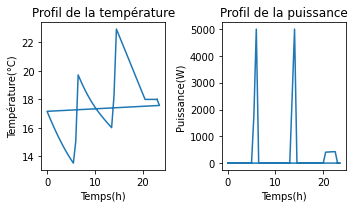

In [47]:
#Résultats
T = res.x[:N+1]
P = res.x[N+1:]

#Affichage du résultat:

#Température
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
axes[0].plot(t, T)
axes[0].set_xlabel("Temps(h)")
axes[0].set_ylabel("Température(°C)")
axes[0].set_title("Profil de la température")

axes[1].plot(t, P)
axes[1].set_xlabel("Temps(h)")
axes[1].set_ylabel("Puissance(W)")
axes[1].set_title("Profil de la puissance")

plt.tight_layout()
plt.show()